# Titanic: Machine Learning from Disaster
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we are tasked to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to create a binary classification model capable of predicting which passengers survived the tragedy.

In [1]:
import os
import warnings 
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Data Exploration and Preparation for Models

In [2]:
df = pd.read_csv(os.path.join('source_data', 'train.csv'))  # data frame of training data supplied by kaggle
df.head()  # first five rows of data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df.isna().any()  # Review Columns (Features) Available and Discover if any information is missing

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [5]:
sex_mapping = {'male': 0, 'female': 1}  # Codify and map Sex strings to integer values
df['Sex'] = df['Sex'].map(sex_mapping)

In [10]:
df["Age"].fillna(28.0, inplace=True)  # Replace null data in Age column with the median Age = 28.0

#### Data Dictionary
<ol>
    <li><b>PassengerId</b>: 	Passenger unique ID, useful for submission of solution</li>
    <li><b>Survived</b>: 	Binary value for survived:	0 = No, 1 = Yes</li>
    <li><b>Pclass</b>: 	 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd</li>
    <li><b>Name</b>: 	 	Passenger's Name - string</li>
    <li><b>Sex</b>: Passenger's Sex</li>
    <li><b>Age</b>: 	 	Passenger's Age in years 	</li>
    <li><b>SibSp</b>: 	 	# of siblings / spouses aboard the Titanic 	</li>
    <li><b>Parch</b>: 	 	# of parents / children aboard the Titanic 	</li>
    <li><b>Ticket</b>: 	 	Ticket number 	</li>
    <li><b>Fare</b>: 	 	Passenger fare 	</li>
    <li><b>Cabin</b>: 	 	Cabin number 	</li>
    <li><b>Embarked</b>: 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton</li>
</ol>

In this analysis we will be leveraging the background information that women, children, and the upper-class were more likey to survive. In this notebook, analysis will be carrying forward the obviously useful features of `Pclass`, `Sex`, and `Age` to develop a classification model along with the feature of `Survived` which is our target label. 

The data point of `Fare` may also be useful with ascertaining finer resolution on a passenger's socio-economic class, but given its distribution, is it meaningful to train and predict with? It appears to have several 0.0 values which may be glorified nulls along with what may be some erroneously high fare outliers.

`Sex` as noted, is a useful feature but currently populated with "male" and "female" strings, a column of codified data will have to be created to replace it before it is a useful feature for machine learning algorithms.

`Age` should be a useful feature but has null values present. Entries with null Age values with need feature engineering. Options include excluding rows with null `Age` values or replacing the null values with median or mean age. Initially, this notebook will proceed by replacing the null `Age` values with the median age of 28.

Regarding "women and children" trend, family connections may or may not prove to be usefulfeature for predicting survival. To that end, the features `SibSp` and `Parch` will be preserved.

Lastly, the feature `PassengerId` will also be preserved as it is an inportant feature for the logistics of the competition submission but will not be used as an input to any machine learning models as it is meaningless to survival.

The remaining features in the data, namely `Name`, `Ticket`, `Cabin`, and `Embarked` will be omitted from the remaining analyses and model training.

In [13]:
features = ["Pclass","Sex","Age","Fare", "SibSp", "Parch"]
target = ["Survived"]
df[features+target].isna().any()  # Make sure no nulls remain in data

Pclass      False
Sex         False
Age         False
Fare        False
SibSp       False
Parch       False
Survived    False
dtype: bool

### Pair Plots and Correlation Heat Maps

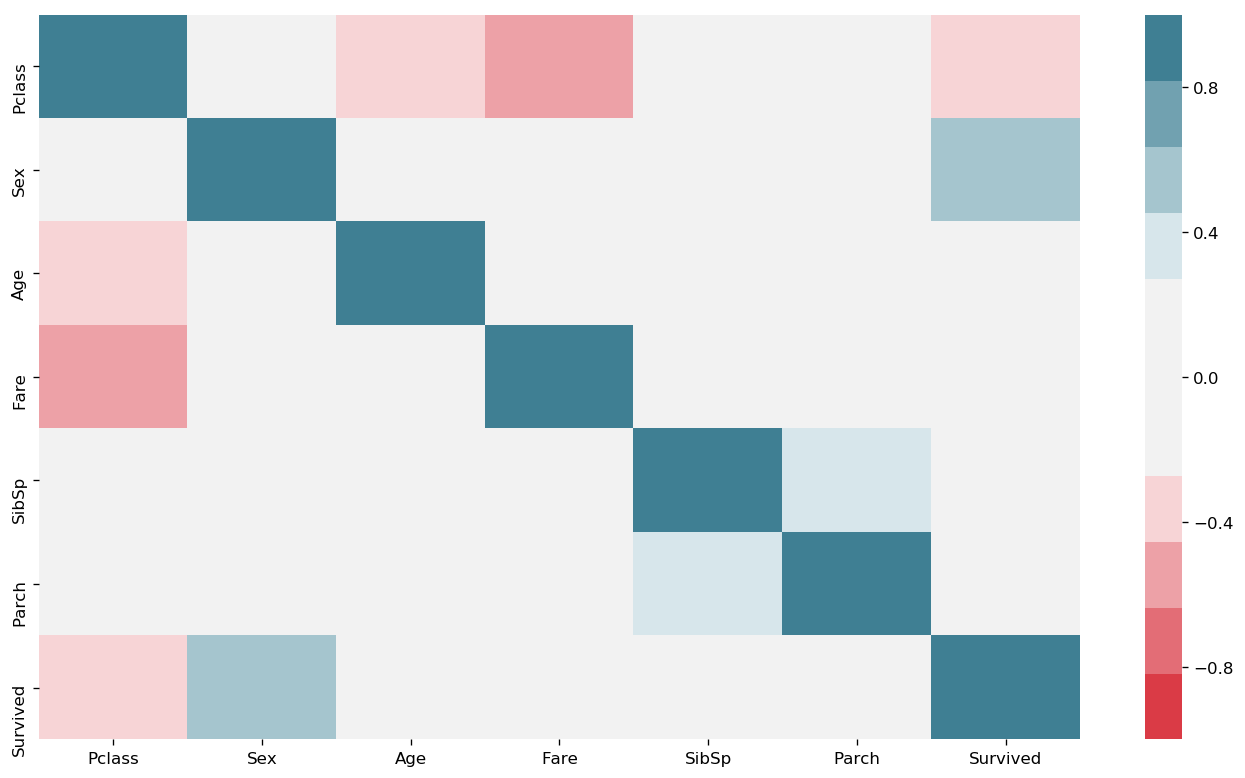

In [9]:
cor = df[features+target].corr()
f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
sns.set_palette("husl")
sns.heatmap(cor, vmin=-1.0, vmax=1.0, cmap=sns.diverging_palette(10, 220, sep=80, n=11)) #, cmap=blues)

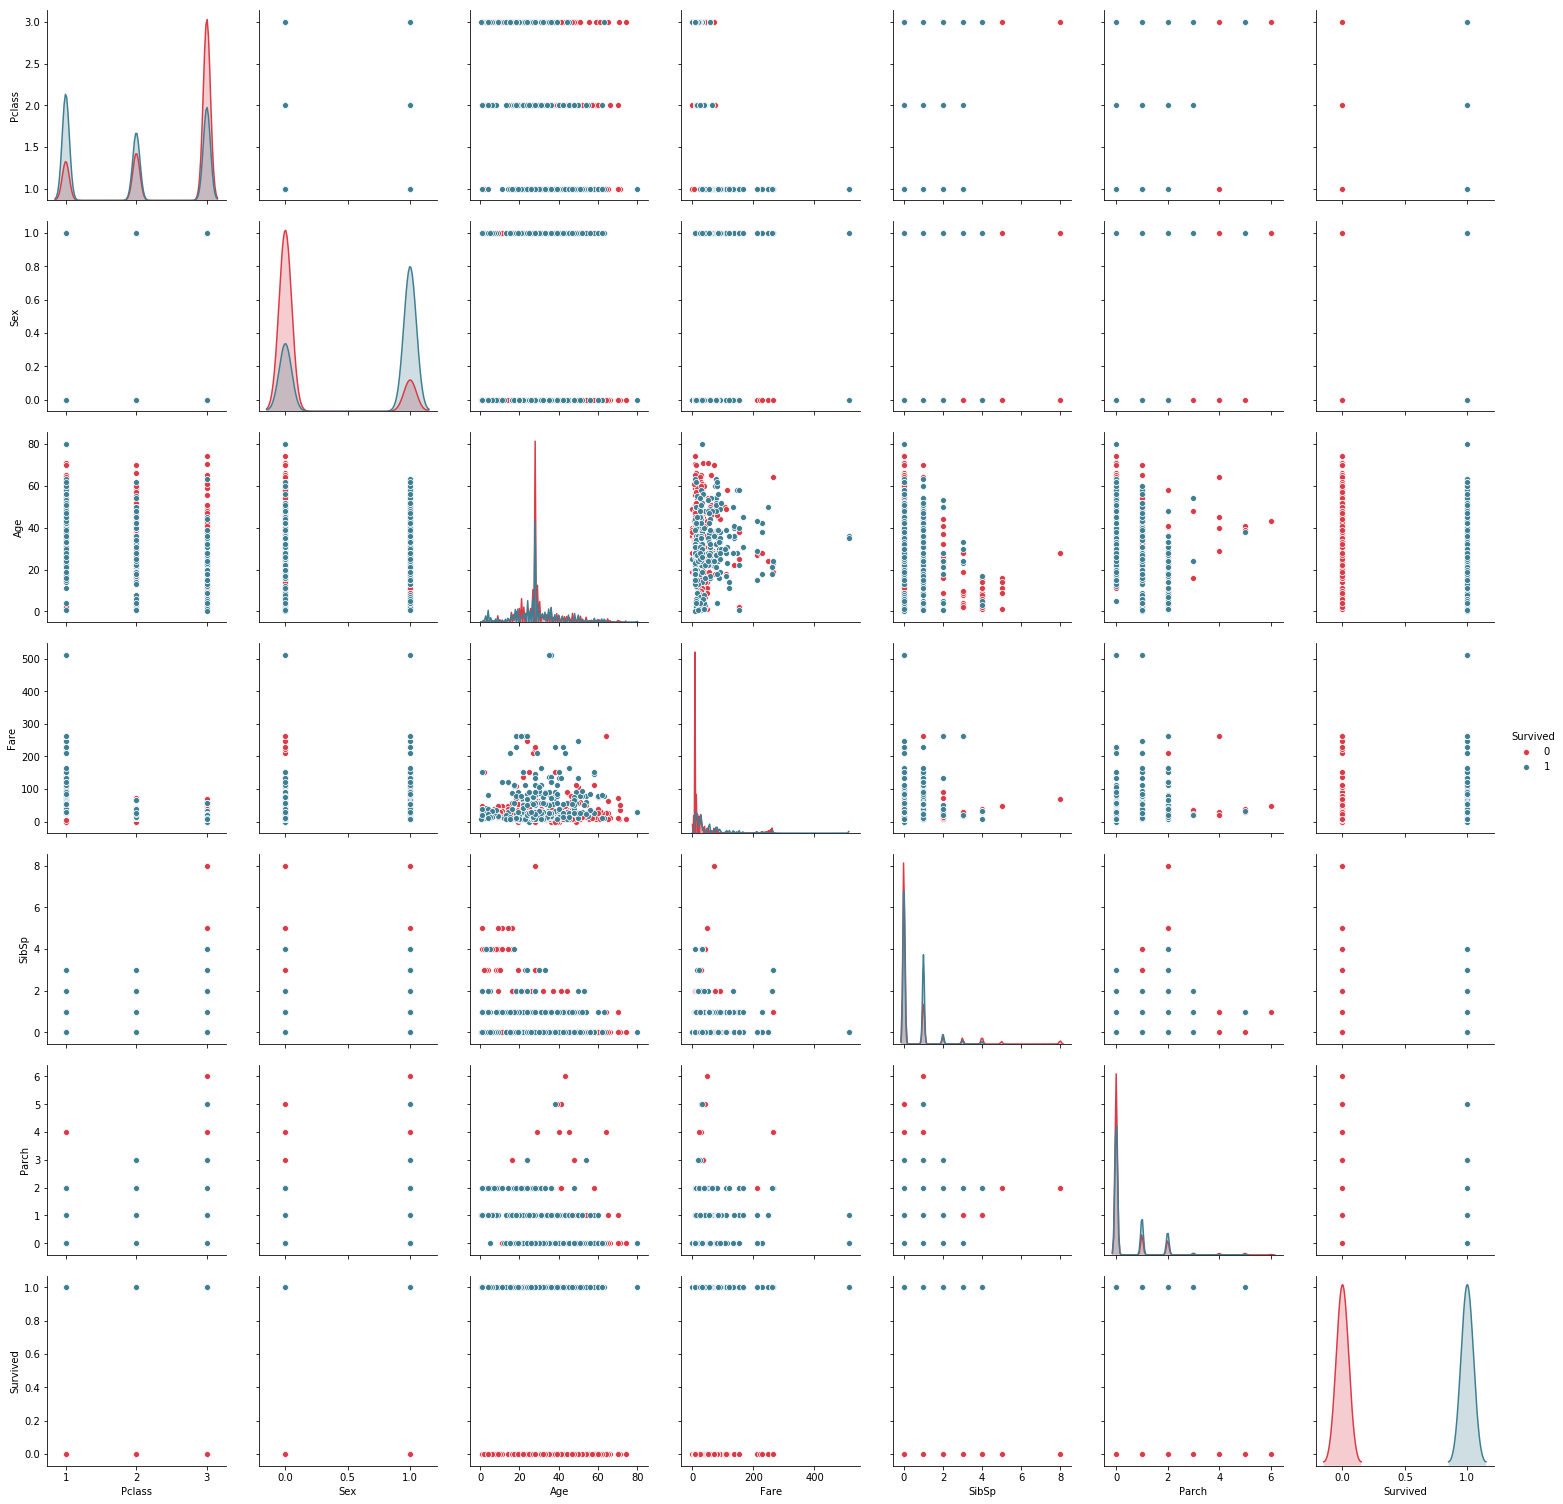

In [12]:
sns.pairplot(df[features+target], hue="Survived", palette=sns.diverging_palette(10, 220, sep=80, n=2), height=3, diag_kind="kde", diag_kws=dict(shade=True, bw=.05, vertical=False) )

Text text text

### Feature Distributions

In [17]:
# Set some styling variables for plots
sns.set_style('whitegrid')
sns.set_palette(sns.diverging_palette(220, 10, sep=80, n=2), 2)

# Define a function to make a bar plot of survivors for each of the categories in the column.
def plot_categorical(x_column, hue_column, df):
    '''Plot a bar plot for the average survivor rate for different groups.
    x_column          (str): The column name of a categorical field.
    hue_column        (str): The column name of a second categorical field.
    df   (pandas.DataFrame): The pandas DataFrame (just use df here!)
    '''
    fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    #plt.figure(figsize=(8, 8))
    sns.barplot(x=x_column, y='Survived', hue=hue_column, data=df, errwidth=0)
    plt.title('Survivors separated by {} and {}'.format(x_column, hue_column))
    plt.show()


# Define a function to plot the distribution for survivors and non-survivors for a continuous variable.
def plot_distribution(column, df):
    '''Plot a bar plot for the average survivor rate for different groups.
    column            (str): The column name of a continuous (numeric) field.
    df   (pandas.DataFrame): The pandas DataFrame (just use df here!)
    '''
    fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    #plt.figure(figsize=(8, 8))
    sns.distplot(df[df['Survived'] == 1][column].dropna(), label='Survived')
    sns.distplot(df[df['Survived'] == 0][column].dropna(), label='Did not survive')
    plt.legend()
    plt.title('{} distribution'.format(column))
    plt.show()

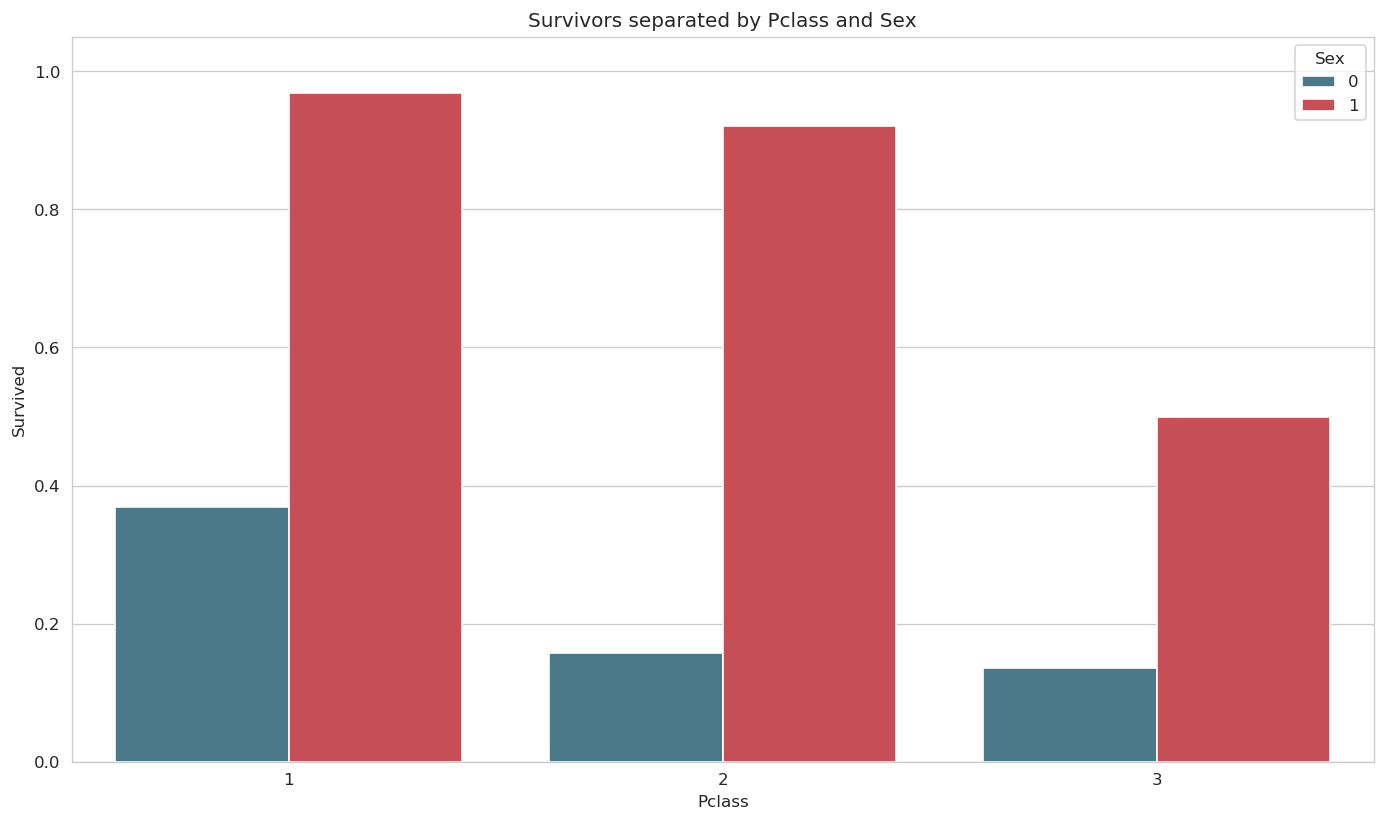

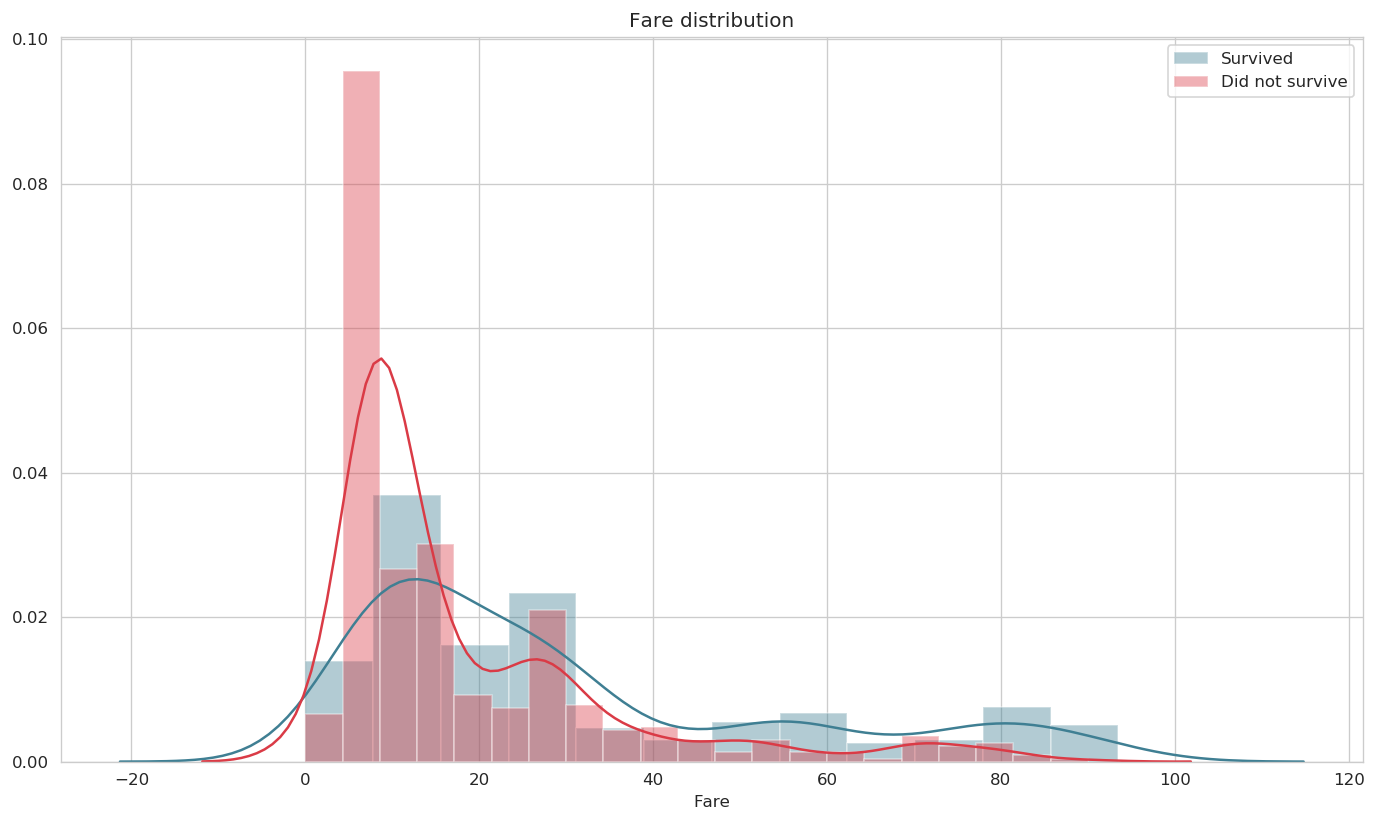

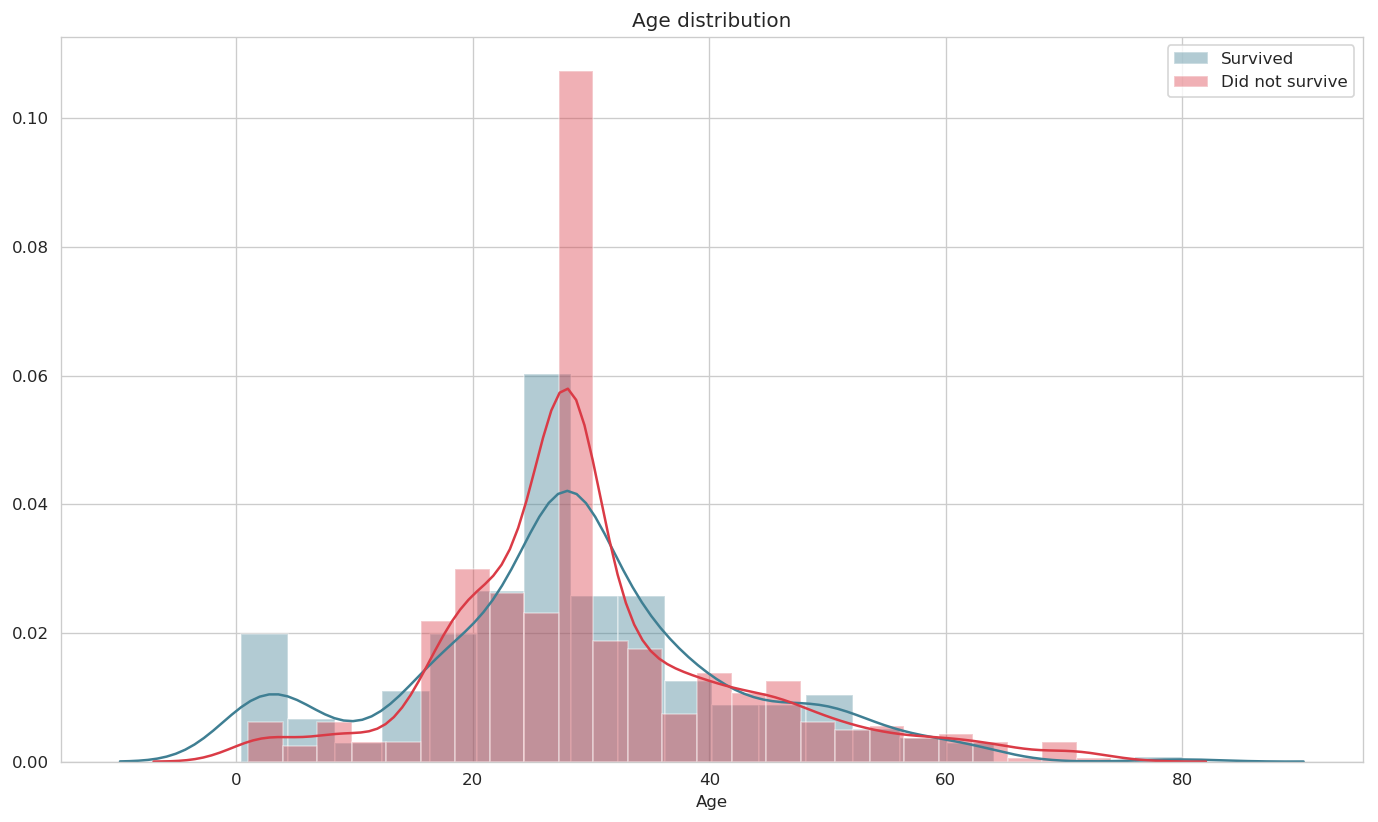

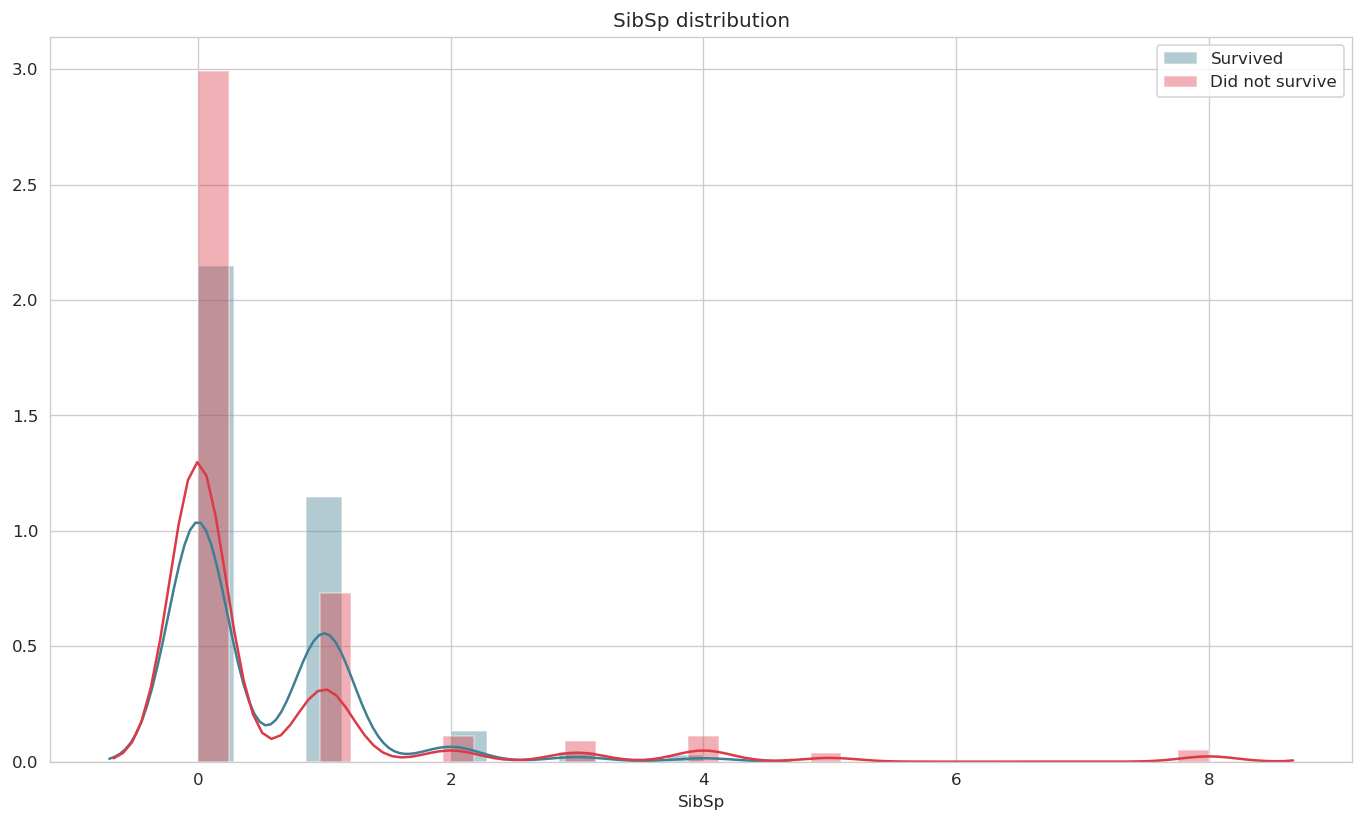

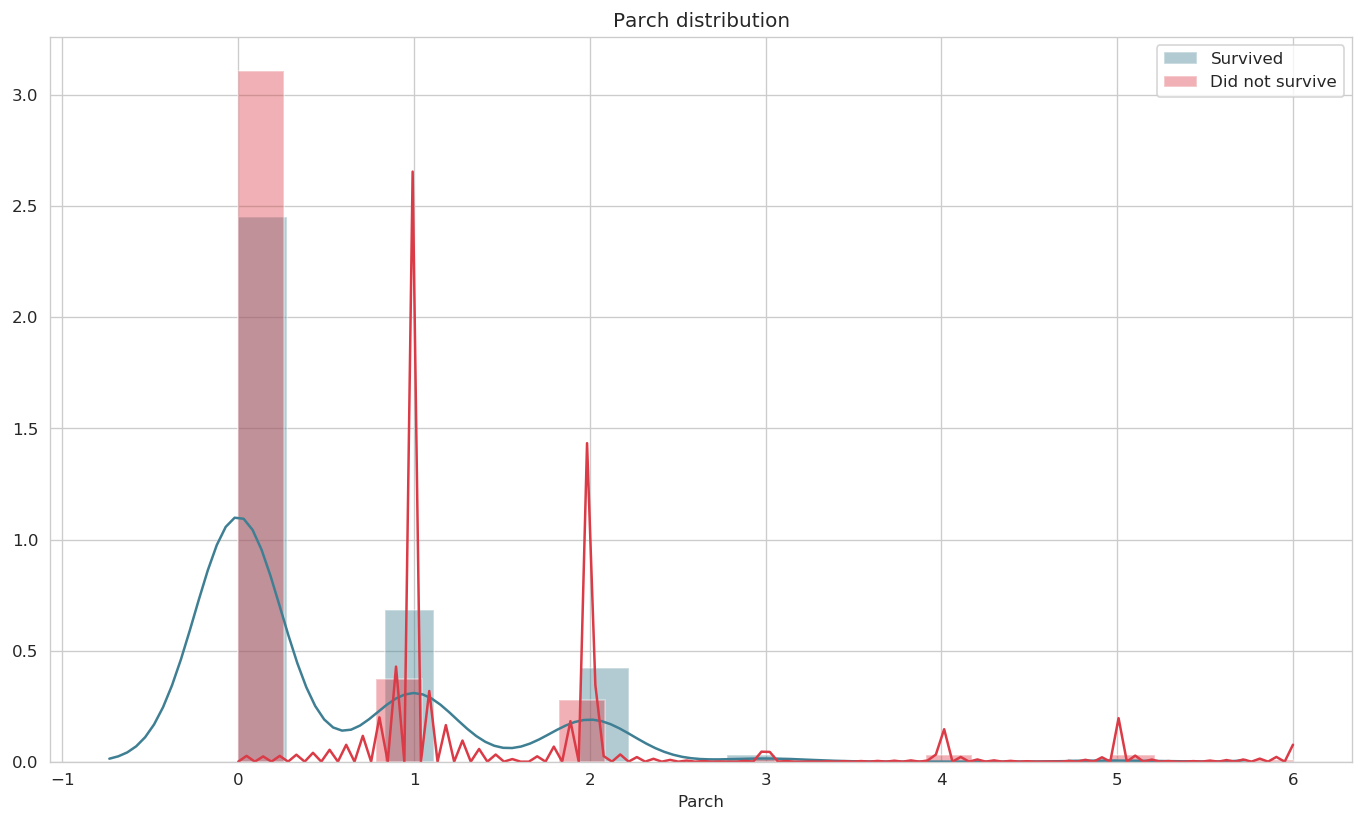

In [22]:
plot_categorical('Pclass', 'Sex', df)  # recall sex 0 = male, 1 = female
plot_distribution('Fare', df[df['Fare'] < 100]) # df[df['Fare'] < 100] simply removes some outliers!
plot_distribution('Age', df)
plot_distribution('SibSp', df)
plot_distribution('Parch', df)

### Data Observations

<ul>
    <li>There were approximately 1.5 times more third-class passengers than first or second class passengers. </li>
    <li>A high percentage of those third-class passengers were men.</li>
    <li>First class passengers skew slightly older than other classes.</li>
    <li>First-class passengers were more likely to survive than die in the tragedy. while third-class passengers had a noticeably low survival rate. </li>
    <li>More women survived than perished while it appears a very low percentage of men survived</li>
    <li>Survival tied to Age is relatively flat but it does appear than some small bias exists that shows favorable survival rates to younger passengers</li>
    </ul>
    
                

## Prototype and Fine Tune Promising Models
This project aims to solve a binary classification problem - given a Titanic passenger's Survival based on their Sex, Age, and Class. 

For this initial investigation, the following two classification models will be explored:
<ul><li>k Nearest Neighbors Classifier</li>
    <li>Support Vector Machine</li>
    </ul>
    
There are other classification models that may or may not be well suited to this problem that could be considered later:
<ul><li>Logistic Regression Classifier</li>
    <li>Decision Trees</li>
    <li>Random Forest</li>
    <li>Naive Bayes</li>
    <li>Neural Networks</li></ul>

### k Nearest Neighbors Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

normalized_features = normalize(df[features], axis=0)

x_train, x_test, y_train, y_test = train_test_split(normalized_features, df[labels], train_size=0.8, test_size=0.2, random_state=1)

k_range = list(range(3,17,2))
m_accuracy = []
m_recall = []
m_precision = []
m_f1 = []
    
for k in k_range:
    classifier = KNeighborsClassifier(n_neighbors=k)  # Instantiate the Model
    classifier.fit(x_train, y_train.values.ravel())  # Fit or Train the Model
    y_predicted = classifier.predict(x_test)  # Make Predictions on the Test subset
    m_accuracy.append(accuracy_score(y_test, y_predicted))
    m_recall.append(recall_score(y_test, y_predicted))
    m_precision.append(precision_score(y_test, y_predicted))
    m_f1.append(f1_score(y_test, y_predicted))

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Accuracy', 'Recall', 'Precision', 'F1 Score']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(k_range, m_accuracy, '-', label=plot_labels[0], color=blues[0])
plt.plot(k_range, m_recall, '--', label=plot_labels[1], color=blues[1])
plt.plot(k_range, m_precision, '-.', label=plot_labels[2], color=blues[2])
plt.plot(k_range, m_f1, ':', label=plot_labels[3], color=blues[3])
plt.legend(loc='lower right')
plt.title('K Nearest Neighbors Classification - Performance vs k Value')
plt.xlabel('k Value')
plt.ylabel('Classifier Scores')
plt.show()

In [ ]:
m_accuracy[3]  # Performance peaks for a reasonable k = 9

### Support Vector Machine

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.svm import SVC

normalized_features = normalize(df[features], axis=0)

x_train, x_test, y_train, y_test = train_test_split(normalized_features, df[labels], train_size=0.8, test_size=0.2, random_state=1)

gamma_range = np.linspace(0.05, 3.0, num=30)
kernel_value = "rbf"
scores = []
m_recall = []
m_precision = []
m_f1 = []

for gamma_value in gamma_range:
    classifier = SVC(kernel=kernel_value, gamma=gamma_value)  # Instantiate the Model
    classifier.fit(x_train, y_train.values.ravel())  # Fit or Train the Model
    scores.append(classifier.score(x_test, y_test))
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(gamma_range, scores, '-', label='gamma', color=blues[0])
plt.title('Support Vector Machine Classification - RBF Kernel Performance vs Gamma')
plt.xlabel('Gamma')
plt.ylabel('Classifier Score')
plt.show()

In [ ]:
print("Classifier model score plateaus at "+str(scores[13])+" when gamma >= "+str(gamma_range[13]))

## Load Test Data and Generate Predictions

Use our trained and optimized models to predict suvival for passengers in the "test.csv". Compare the outputs of the two model predictors.

### Create Fine-Tuned Classification Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

normalized_features = normalize(df[features], axis=0)
x_train, x_test, y_train, y_test = train_test_split(normalized_features, df[labels], train_size=0.90, test_size=0.10, random_state=1)

knn_classifier = KNeighborsClassifier(n_neighbors=9)
knn_classifier.fit(x_train, y_train.values.ravel())  # Fit or Train the Model
y_predicted = knn_classifier.predict(x_test)  # Make Predictions on the Test subset
print(accuracy_score(y_test, y_predicted))

svm_classifier = SVC(kernel="rbf", gamma=1.3724)  
svm_classifier.fit(x_train, y_train.values.ravel())  # Fit or Train the Model
print(svm_classifier.score(x_test, y_test))

### Load Test Data and Prepare it for Input to Model

In [ ]:
test_df = pd.read_csv(os.path.join('source_data', 'test.csv'))  # Read in the Test data supplied by kaggle
test_df.head()  # same as train.csv except for the missing Survived column

In [ ]:
features = ["Pclass","Sex","Age"]
labels = ["Survived"]
features_to_remove = ["SibSp","Parch","Ticket","Fare","Cabin","Embarked"]
test_df.drop(features_to_remove, axis=1, inplace=True) 

sex_mapping = {'male': 0, 'female': 1}  # Codify and map Sex strings to integer values
test_df['Sex'] = test_df['Sex'].map(sex_mapping)

test_df["Age"].fillna(28.0, inplace=True)  # Replace null data in Age column with the median Age = 28.0

normalized_test_features = normalize(test_df[features], axis=0)

In [ ]:
test_df["knn_predicted"] = knn_classifier.predict(normalized_test_features)
test_df["svm_predicted"] = svm_classifier.predict(normalized_test_features)

In [ ]:
print(test_df['knn_predicted'].value_counts() / len(test_df))
print(test_df['svm_predicted'].value_counts() / len(test_df))

In [ ]:
o_k = open("knn_submission.csv", "w+")
o_s = open("svm_submission.csv", "w+")

o_k.write("PassengerId,Survived\n")
o_s.write("PassengerId,Survived\n")

for index, row in test_df.iterrows():
    o_k.write(str(row["PassengerId"])+","+str(row["knn_predicted"])+'\n')
    o_s.write(str(row["PassengerId"])+","+str(row["svm_predicted"])+'\n')

o_k.close()
o_s.close()

The competition scored my results as follows:
<ol><li><b>SVM Classifier</b>: 0.76555</li>
    <li><b>kNN Classifier</b>: 0.74162</li></ol>